## Project Description

A hands-on project to build a model which can detect whether a sentence is sarcastic or not using Bidirectional LSTMs.

## Dataset 

Here we are using the **News Headlines dataset for Sarcasm Detection** over the Twitter dataset.

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

The News Headlines dataset for Sarcasm detection is collected from two news websites "theonion.com" and "huffingtonpost.com" which has the following advantages over the Twitter datasets:
* Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings
* Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets
* Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

## Content

Each record consists of three attributes:
* is_sarcastic: 1 if the record is sarcastic otherwise 0
* headline: the headline of the news article
* article_link: link to the original news article. Useful in collecting supplementary data.



## Acknowledgement

Rishabh Misra and Prahal Arora - "Sarcasm Detection using Hybrid Neural Network" - arXiv preprint arXiv:1908.07414, 2019 (https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection)  

## Objective

The objective of this task is to build a model which can detect whether a sentence is sarcastic or not using Bidirectional LSTMs.

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.0'

In [2]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Change current working directory to project folder

In [3]:
import os
cwd_old = os.getcwd()
print('\nWorking directory: ', cwd_old)

os.chdir('/content/gdrive/MyDrive/AIML/Projects/NLP/Sarcasm Detection')
print('Working directory has changed')

# verifying the current directory has changed
cwd_new = os.getcwd()
print('\nCurrent Working directory: ', cwd_new)


Working directory:  /content
Working directory has changed

Current Working directory:  /content/gdrive/MyDrive/AIML/Projects/NLP/Sarcasm Detection


#### Import Packages

In [4]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
## Initialize the random number generator

random_state = 42
tensorflow.random.set_seed(random_state)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import string
import re

# For text preprocessing and stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')

# Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#### Load data

In [7]:
data = pd.read_json('/content/gdrive/MyDrive/AIML/Projects/NLP/Sarcasm Detection/Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. The first five headlines in the dataset along with their category are:')
display(data.head())

Data has 26709 rows and 3 columns. The first five headlines in the dataset along with their category are:


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Is sarcastic count: 11724 i.e., 44.0%
Isn't sarcastic count: 14985 i.e., 56.0%
Distribution of sarcastic label


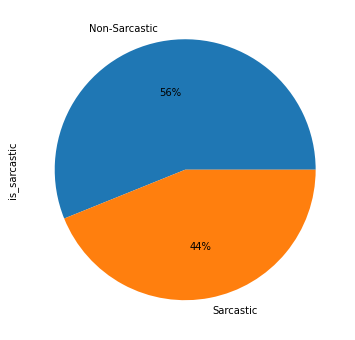

In [8]:
print(f'Is sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e., {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e., {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')
print('Distribution of sarcastic label')
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Non-Sarcastic', 'Sarcastic'], figsize = (10, 6))

In [9]:
print('Analysis of of `is_sarcastic` label by news website')

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-Sarcastic']))

Analysis of of `is_sarcastic` label by news website


,huffingtonpost,theonion
Sarcastic,0,11724
Non-Sarcastic,14985,1


#### Observations

* There are 26709 sentences in the dataset out of which 44% (i.e., 11724) are sarcastic sentences and the rest 56% (i.e., 14985) are non-sarcastic statements
* There are no headlines from Huffington Post that are sarcastic whereas all but one headlines from The Onion are sarcastic.



#### Drop article_link from dataset

In [10]:
data.drop('article_link', axis = 1, inplace = True)
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


#### Data Preprocessing

In [11]:
substitute = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
              "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
              "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
              "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
              "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
              "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
              "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
              "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it would",
              "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
              "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
              "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
              "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
              "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
              "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
              "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
              "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that had",
              "that'd've": "that would have", "that's": "that that is", "there'd": "there would", "there'd've": "there would have",
              "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
              "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
              "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
              "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
              "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
              "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
              "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
              "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
              "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
              "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
              "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
              "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are",
              "you've": "you have"}

# Function to replace substitute
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in substitute.keys():
            cleaned_headlines.append(substitute[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Function to remove punctuations
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punct))

# Function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

# Function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stoplist])

# Second function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

In [12]:
## Converting headlines to lower case
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

## Replacing apostrophes to the standard lexicons
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

## Removing punctuations
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

## Applying Lemmatizer
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

## Removing multiple spaces between words
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

In [13]:
print('After preprocessing the dataset turns out to be as')
data.head()

After preprocessing the dataset turns out to be as


,headline,is_sarcastic,cleaned_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...


#### Get length of each headline and add a column for that 

In [14]:
data['headline_length'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))
print('Currently the dataset stands out as:')
data.head()

Currently the dataset stands out as:


,headline,is_sarcastic,cleaned_headline,headline_length
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue over secret bla...,12
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catch up to our thorny po...,14
2,mom starting to fear son's web series closest ...,1,mom starting to fear son web series closest th...,14
3,"boehner just wants wife to listen, not come up...",1,boehner just want wife to listen not come up w...,13
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wish snape happy birthday in the mo...,11


In [15]:
print('Minimum number of words: {}'.format(data['headline_length'].min()))
print('Headline with minimum number of words: {}'.format(data[data['headline_length'] == data['headline_length'].min()]['cleaned_headline'].values[0]))
print('Minimum number of words: {}'.format(data['headline_length'].max()))
print('Headline with maximum number of words: {}'.format(data[data['headline_length'] == data['headline_length'].max()]['cleaned_headline'].values[0]))

Minimum number of words: 2
Headline with minimum number of words: breaking uniform
Minimum number of words: 39
Headline with maximum number of words: elmore leonard modern prose master noted for his terse prose style and for writing about thing perfectly and succinctly with a remarkable economy of word unfortunately and sadly expired this gloomy tuesday at the age of 87 year old


In [16]:
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, figure_size = (12,6), title = None, title_size = 15):
  wordcloud = WordCloud(background_color = 'white', max_words = max_words, random_state = 42, width = 350, height = 150,
                        mask = mask, stopwords = stoplist, collocations = False)
  wordcloud.generate(str(text))
  
  plt.figure(figsize = figure_size)
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.title(title, fontdict = {'size': title_size, 'color': 'black', 'verticalalignment': 'bottom'})
  plt.axis('off')
  plt.tight_layout()

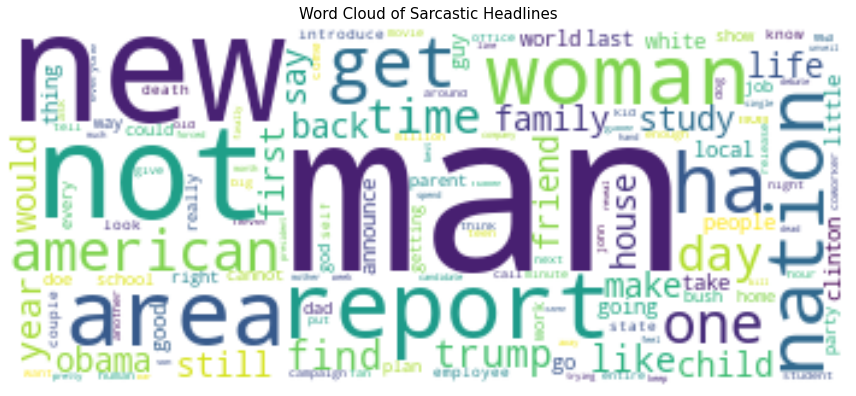

In [17]:
data['headline'] = data['headline'].fillna('')
sarcastic_headline = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headline, title = 'Word Cloud of Sarcastic Headlines')

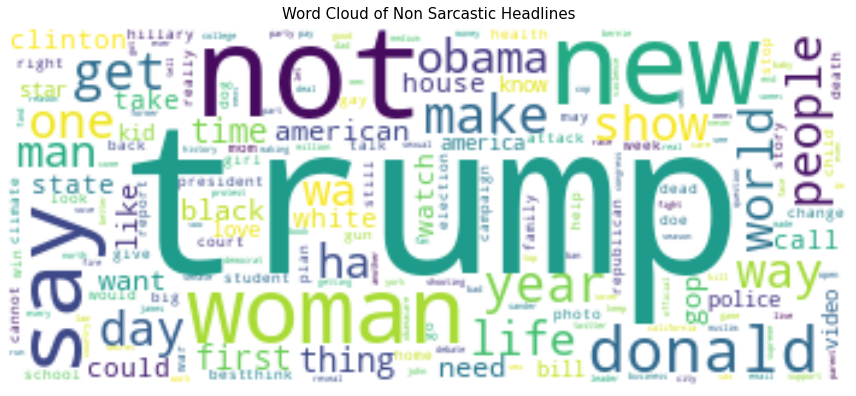

In [18]:
non_sarcastic_headline = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headline, title = 'Word Cloud of Non Sarcastic Headlines')

#### Initialize parameter values
* Set values for max_features, maxlen and embedding_size
* **max_features**: Number of words to take from tokenizer(most frequent words)
* **maxlen**: Maximum length of each sentence to be limited to 25
* **embedding_size**: Size of embedding vector



In [19]:
max_features = 10000
maxlen = 25
embedding_size = 200 

#### Apply `tensorflow.keras` Tokenizer and get indices for words
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [20]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))
X = tokenizer.texts_to_sequences(data['cleaned_headline'])

#### Pad sequences
- Pad each example with a maximum length
- Convert target column into numpy array

In [21]:
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of samples: {len(X)}')
print(f'Number of samples: {len(y)}')
print(f'\nFirst Headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of samples: 26709
Number of samples: 26709

First Headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  327  686 2924 1254   54  291  107 1915    6 2014 3610]

Label of the first headline: 0


#### Vocab mapping
- There is no word for 0th index

In [22]:
w2i = tokenizer.word_index

#### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [23]:
num_words = len(w2i) + 1
print(f'Number of unique tokens: {num_words}')

Number of unique tokens: 24962


#### Load Glove Word Embeddings

In [24]:
glove_file = '/content/gdrive/MyDrive/AIML/Projects/NLP/Sarcasm Detection/glove.6B.zip'

from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

#### Create embedding matrix

In [25]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
  word = o.split(' ')[0]
  embd = o.split(' ')[1:]
  embd = np.asarray(embd, dtype = 'float32')
  embeddings[word] = embd

## create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

#### Splitting the dataset into Training and Test data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print(f'Number of rows in training dataset: {X_train.shape[0]}')
print(f'Number of columns in training dataset: {X_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(X_train)))}')

print(f'Number of rows in test dataset: {X_test.shape[0]}')
print(f'Number of columns in test dataset: {X_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(X_test)))}')

Number of rows in training dataset: 21367
Number of columns in training dataset: 25
Number of unique words in training dataset: 9958
Number of rows in test dataset: 5342
Number of columns in test dataset: 25
Number of unique words in test dataset: 7397


#### Define model
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [27]:
def create_model():
  sarcasm_detection_model = Sequential([
                                Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False),
                                Bidirectional(LSTM(512, return_sequences = True)),
                                GlobalMaxPool1D(),
                                Dense(256, activation = 'relu'),
                                Dropout(0.5, input_shape = (256,)),
                                Dense(128, activation = 'relu'),
                                Dropout(0.5, input_shape = (128, )),
                                Dense(64, activation = 'relu'),
                                Dropout(0.5, input_shape = (64, )),
                                Flatten(),
                                Dense(1, activation = 'sigmoid')])

  return sarcasm_detection_model

#### Print the model summary

In [28]:
model = create_model()

# printing out model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           4992400   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 1024)          2920448   
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

#### Compile the model

In [29]:
init_lr = 1e-4
epochs = 10

opt = Adam(lr = init_lr, decay = (init_lr/epochs))
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [30]:
batch_size = 32

# Creating a callback that saves the model
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor = 'val_loss', save_best_only = True, mode = 'auto')
stop = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')

#### Fit the model

In [31]:
model.fit(X_train, y_train, validation_split = 0.2, epochs = epochs, batch_size = batch_size, callbacks = [checkpoint, stop])

Epoch 1/10
535/535 [==============================] - 330s 610ms/step - loss: 0.6723 - accuracy: 0.5670 - val_loss: 0.4866 - val_accuracy: 0.7761


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: model-001.model/assets


Epoch 2/10
535/535 [==============================] - 360s 673ms/step - loss: 0.5120 - accuracy: 0.7680 - val_loss: 0.4431 - val_accuracy: 0.7953


INFO:tensorflow:Assets written to: model-002.model/assets


INFO:tensorflow:Assets written to: model-002.model/assets


Epoch 3/10
535/535 [==============================] - 342s 640ms/step - loss: 0.4499 - accuracy: 0.8017 - val_loss: 0.4069 - val_accuracy: 0.8107


INFO:tensorflow:Assets written to: model-003.model/assets


INFO:tensorflow:Assets written to: model-003.model/assets


Epoch 4/10
535/535 [==============================] - 329s 616ms/step - loss: 0.3941 - accuracy: 0.8346 - val_loss: 0.3786 - val_accuracy: 0.8276


INFO:tensorflow:Assets written to: model-004.model/assets


INFO:tensorflow:Assets written to: model-004.model/assets


Epoch 5/10
535/535 [==============================] - 328s 613ms/step - loss: 0.3511 - accuracy: 0.8547 - val_loss: 0.3519 - val_accuracy: 0.8472


INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: model-005.model/assets


Epoch 6/10
535/535 [==============================] - 326s 609ms/step - loss: 0.2999 - accuracy: 0.8786 - val_loss: 0.3440 - val_accuracy: 0.8498


INFO:tensorflow:Assets written to: model-006.model/assets


INFO:tensorflow:Assets written to: model-006.model/assets


Epoch 7/10
535/535 [==============================] - 328s 613ms/step - loss: 0.2428 - accuracy: 0.9088 - val_loss: 0.3464 - val_accuracy: 0.8582
Epoch 8/10
535/535 [==============================] - 326s 609ms/step - loss: 0.2001 - accuracy: 0.9312 - val_loss: 0.3855 - val_accuracy: 0.8498
Epoch 9/10
535/535 [==============================] - 326s 610ms/step - loss: 0.1588 - accuracy: 0.9436 - val_loss: 0.4316 - val_accuracy: 0.8435
Epoch 10/10
535/535 [==============================] - 329s 615ms/step - loss: 0.1144 - accuracy: 0.9619 - val_loss: 0.4261 - val_accuracy: 0.8591


#### Evaluate the model

In [32]:
# Load the previously saved model
model = load_model('model-006.model')

# Evaluation of model
training_loss, training_accuracy = model.evaluate(X_train, y_train)
print('Training Loss: %.4f and Training Accuracy: %.2f%%' % (training_loss, training_accuracy * 100))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Loss on test set: %.4f and Accuracy on Test Set: %.2f%%' % (test_loss, test_accuracy * 100)) 

668/668 [==============================] - 78s 116ms/step - loss: 0.2473 - accuracy: 0.9022
Training Loss: 0.2473 and Training Accuracy: 90.22%
167/167 [==============================] - 20s 117ms/step - loss: 0.3416 - accuracy: 0.8517
Loss on test set: 0.3416 and Accuracy on Test Set: 85.17%


In [33]:
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2768
           1       0.88      0.80      0.84      2574

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342



Text(0.5, 1.0, 'Confusion Matrix')

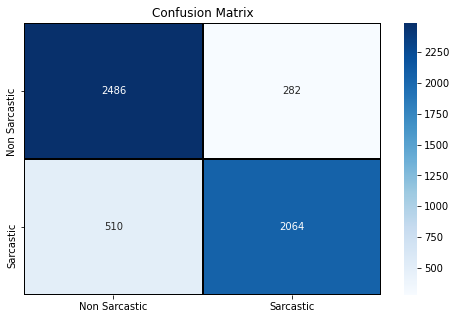

In [34]:
cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize = (8,5))
sns.heatmap(cm, cmap = 'Blues', linecolor = 'black', linewidths = 1, annot = True,
            fmt = '', xticklabels = ['Non Sarcastic', 'Sarcastic'], 
            yticklabels = ['Non Sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

#### Conclusion

From the given task we were able to conclude the following points:
* Here, for the task of building a model which can detect whether a statement is sarcastic or not, we have used the News Headlines Dataset
* For 26709 headlines in the observation:
  * 44% of the data (i.e., 11724) have sarcastic labels whereas 56% (i.e., 14985) don't
  * Moreover, there are no headlines from Huffington Post that are sarcastic whereas all but one from The Onion are sarcastic
* We used data pre-processing techniques to clean headlines, such as:
  * Converting to lower case
  * Converting to standard lexicons such as it's to it is
  * Remove punctuations
  * Lemmatize
  * Remove multiple spaces
* To create the model we used Glove embedding layer with Bidirectional LSTM layer
* While evaluating, we applied the principle of Transfer Learning which enabled us to attain an accuracy of 90.22% on training set whereas 85.17% on the test set
* From the confusion matrix, we can say that out of originally 2768 non-sarcastic headlines present in the test set, the model was able to correctly identify 2486 headlines as non-sarcastic. The rest were classified as sarcastic. Similarly, for 2574 originally sarcastic headlines present in test set, the model was able to correctly identify 2064 headlines as sarcastic. The rest were classified as non-sarcastic.